### Functions from the paper:
 - 1) $\min\{\exp(\frac{-1}{(1+x)^2}),x+\cos(x)\}$. Reason: Evaluate performance for pasted functions and general badness.
 - 2) $\cos(\exp(-x))$.  Reason: Evaluate performance for non-periodic osculations.
 - 3) $I_{(-\infty,\frac1{2})}$.  Reason: Evaluation performance on a single jump.  
 
 ---

# Generate Training Data

In [1]:
# First Round Initializations (Global Level) #
#============================================#
# Load Dependances and makes path(s)
exec(open('Initializations_Dump.py').read())
# Load Hyper( and meta) parameter(s)
exec(open('HyperParameter_Grid.py').read())
# %run Helper_Functions.ipynb
exec(open('Helper_Functions.py').read())
# Load Models
# %run Architecture_Builder.ipynb
exec(open('Architecture_Builder.py').read())

Using TensorFlow backend.


Parameter Grids Build and Loaded!
Complete NEU-Structure Building Procedure!!!
Complete NEU-Structure Building Procedure!!!
Complete NEU-ffNN Training Procedure!!!
Deep Feature Builder - Ready
Complete NEU-ffNN Training Procedure!!!
Complete NEU-ffNN Training Procedure!!!
Complete NEU-ffNN (Fully Coupled) Training Procedure!!!
Complete NEU-ffNN Training Procedure!!!
Complete NEU-ffNN Training Procedure!!!


When generating data...you may use one of the following options:
- For evaluating non-localy patterns: "nonlocality"
- For evaluating model performance when faced with non-stationary osculatory behaviour: "oscilatory"
- For evaluating jump-type performance when faced with a discontinuity: "jumpdiscontinuity"
- For fun/debugging/sanity checking: "the_nightmare"

Simulation Confiugration Information:
 
We're plotting the function: jumpdiscontinuity with 0.1 additive noise, a distortion/model uncertainty level of 0.1, and an out-of sample window on either side of the input space of: 0.  We train using 1000 datapoints and have a test set conisting of 0.75% percent of the total generated data.
 


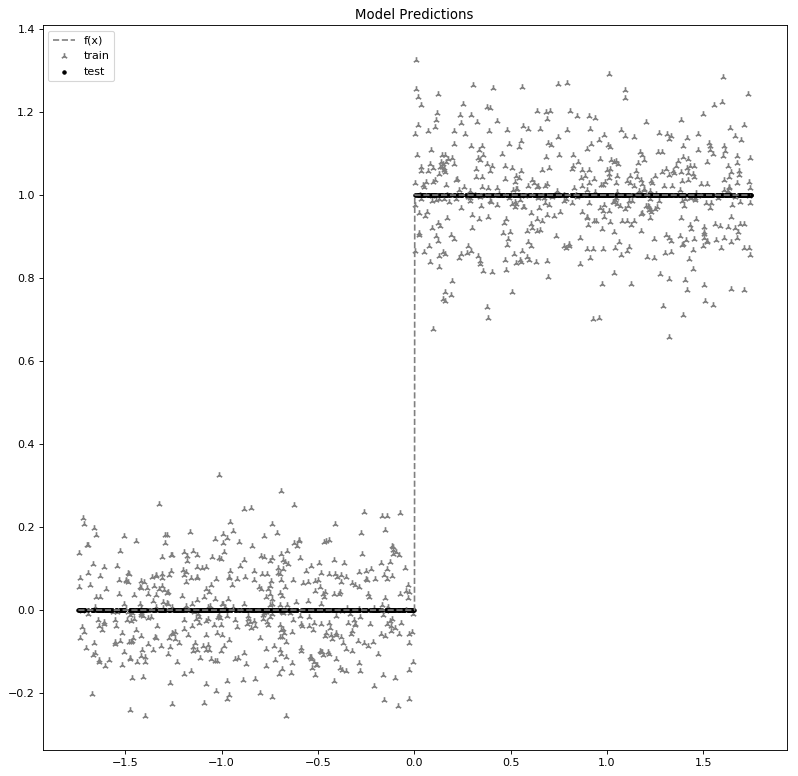

In [2]:
#------------------------#
# Run External Notebooks #
#------------------------#
# %run Data_Generator.ipynb
exec(open('Data_Generator.py').read())

**TEMP:**

Data Driven Robustness Rule:
Using [this article](https://www.sciencedirect.com/science/article/pii/S0378375815000403) for the variance estimate.  
$$
\hat{\sigma}^2 \triangleq
\frac1{(n-1)}\sum_{1<n\leq N} (y_n - y_{n-1})^2
.
$$

We couple it to the problem via the following
$$
\underset{\underset{0\leq w_n\leq 1}{\sum_{n\leq N} w_n=1}}{\operatorname{argmax}} \sum_{n\leq N} w_n L(f(x_n),\hat{f}(x_n),x_n) - \sigma^2 \sum_{n\leq N} w_n \ln\left(\frac{w_n}{N}\right)
.
$$

In [3]:
# GET STATISTICAL VARIANCE ESTIMATE
var_estimate = np.sum(np.diff(data_y)**2)/(((data_y.shape[0])-1))
var_estimate = np.float(round(var_estimate,3))


robustness_dictionary = {'robustness_parameter': [var_estimate*factor,var_estimate*2*factor,var_estimate*3*factor]}
#==================================================================================#        
### Create NEU parameter disctionary by parameters joining model it is upgrading ###
#==================================================================================#
param_grid_NEU_Nets = {**param_grid_NEU_Nets,
                       **robustness_dictionary}

param_grid_NEU_Feature_Only_Nets = {**param_grid_NEU_Feature_Only_Nets,
                                    **robustness_dictionary}

NEU_Structure_Dictionary = {**NEU_Structure_Dictionary,
                            **robustness_dictionary}

# NEU OLS Keys
param_grid_NEU_Reg_Nets = {**param_grid_NEU_Nets,
                           **robustness_dictionary}

param_grid_NEU_Reg_Nets.pop('height', None)
param_grid_NEU_Reg_Nets.pop('depth', None)
print(" ")

# Benchmark Models

Run univariate regression benchmarks file:

In [4]:
# %run Univariate_Regression_Benchmark_Models.ipynb
exec(open('Univariate_Regression_Benchmark_Models.py').read())

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    0.9s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    0.7s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    3.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    3.4s finished


Epoch 1/2
125/125 [==============================] - 0s 945us/step - loss: 0.5334 - mse: 0.4872 - mae: 0.5334 - mape: 164.3790
Epoch 2/2
125/125 [==============================] - 0s 640us/step
Benchmark-Model: Saving
Benchmark-Model: Saved


---
# Train Feature Map for "decoupled" NEU-*Model(s)*
---

We train NEU's universal linearizing feature map.

In [5]:
tf.random.set_seed(2020)

start = time.time()
# 1+2) Learn Linearizing Feature Map #
#====================================#
# Obtain NEU-OLS predictions and Model
NEU_OLS_y_hat_train_pre, NEU_OLS_y_hat_test_pre, NEU_OLS = build_NEU_OLS(n_folds = CV_folds, 
                                                           n_jobs = n_jobs, 
                                                           n_iter = n_iter, 
                                                           param_grid_in = param_grid_NEU_Feature_Only_Nets, 
                                                           X_train = data_x, 
                                                           y_train = data_y,
                                                           X_test = data_x_test)
# Extract Linearizing Feature Map
Linearizing_Feature_Map = extract_trained_feature_map(NEU_OLS.model)

# Pre-process Linearized Data #
#=============================#
# Get Linearized Predictions #
#----------------------------#
data_x_featured_train = Linearizing_Feature_Map.predict(data_x)
data_x_featured_test = Linearizing_Feature_Map.predict(data_x_test)
# Coerce data into form ready for NEU-Structure Map
data_x_NEU_train = np.concatenate([data_x_featured_train,data_x.reshape(-1,D)],axis=1)
data_x_NEU_test = np.concatenate([data_x_featured_test,data_x_test.reshape(-1,D)],axis=1)


# Extract Feature Data Only (for De-coupled Implementations of Step 2) #
#----------------------------------------------------------------------#
data_x_NEU_train_feature_only = data_x_NEU_train[:,:d]
data_x_NEU_test_feature_only = data_x_NEU_test[:,:d]

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    7.9s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    7.9s finished


Epoch 1/2
125/125 [==============================] - 0s 2ms/step - loss: 0.5723 - mse: 0.5077 - mae: 0.5425 - mape: 119.2512
Epoch 2/2
125/125 [==============================] - 0s 1ms/step
NEU-OLS: Trained!
NEU-OLS: Saving
NEU-OLS: Saved


---
# Linear Model(s)
---

### NEU-Linear *(decoupled implementation)*

In [6]:
# 2) Perform Linear Regression on Feature-Space #
#===============================================#
#====================================#
# Ordinary Linear Regression Version #
#====================================#
NEU_lin_reg = LinearRegression()
NEU_lin_reg.fit(data_x_featured_train,data_y)
NEU_OLS_train = NEU_lin_reg.predict(data_x_featured_test)
NEU_OLS_test = NEU_lin_reg.predict(data_x_featured_train)

#=====================#
# Elastic Net Version #
#=====================#
# Block warnings that spam when performing coordinate descent (by default) in 1-d.
import warnings
warnings.filterwarnings("ignore")
# Initialize Elastic Net Regularization Model
if trial_run == True: # Fast version for trial
    NEU_lin_reg = ElasticNetCV(cv=5, 
                               random_state=0, 
                               alphas = np.linspace(0,(10**2),5),
                               l1_ratio = np.linspace(0,1,5))
else: #Slow Version for real-deal
    NEU_lin_reg = ElasticNetCV(cv=5, 
                               random_state=0, 
                               alphas = np.linspace(0,(10**2),(10**2)),
                               l1_ratio=np.linspace(0,1,(10**2)))
# Fit Elastic Net Model
NEU_lin_reg.fit(data_x_featured_train,data_y)

ElasticNetCV(alphas=array([  0.,  25.,  50.,  75., 100.]), copy_X=True, cv=5,
             eps=0.001, fit_intercept=True,
             l1_ratio=array([0.  , 0.25, 0.5 , 0.75, 1.  ]), max_iter=1000,
             n_alphas=100, n_jobs=None, normalize=False, positive=False,
             precompute='auto', random_state=0, selection='cyclic', tol=0.0001,
             verbose=0)

In [7]:
# Pre-process Linearized Data #
#=============================#
# Get Linearized Predictions #
#----------------------------#
# Produce Prediction(s)
NEU_OLS_y_hat_train = NEU_lin_reg.predict(data_x_featured_train)
NEU_OLS_y_hat_test = NEU_lin_reg.predict(data_x_featured_test)

NEU_OLS_y_hat_train_FC = NEU_OLS_train
NEU_OLS_y_hat_test_FC = NEU_OLS_test

end = time.time()

#### Visualization of Feature Space


Embedding Dimension: 2


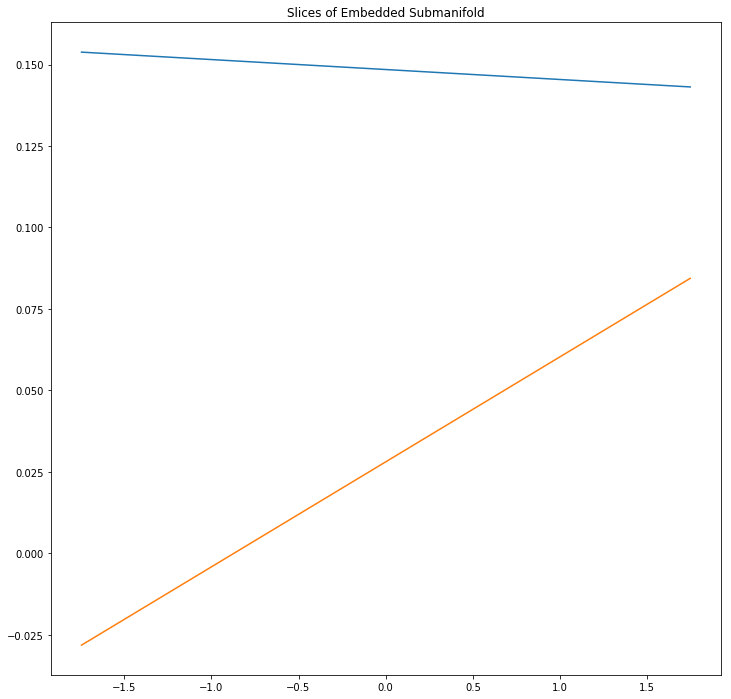

In [8]:
print()
Embedding = pd.DataFrame(data_x_featured_test,index=data_x_test.reshape(-1,), columns=range(0,data_x_featured_test.shape[1]))
# Format Plot #
#-------------#
fig = Embedding.plot(figsize=(12, 12))
fig.get_legend().remove()
plt.title("Slices of Embedded Submanifold")
print("Embedding Dimension: "+str(data_x_featured_test.shape[1]))

# SAVE Figure to .eps
plt.savefig('./outputs/plotsANDfigures/Sliced_Manifold_Embedding_with_N_Dimensions_'+str(data_x_featured_test.shape[1])+'.pdf', format='pdf')
# Show Plot
if is_visuallty_verbose == True:
    plt.show(block=False)

#### Visual Comaprison between the OLS and the NEU-OLS models:

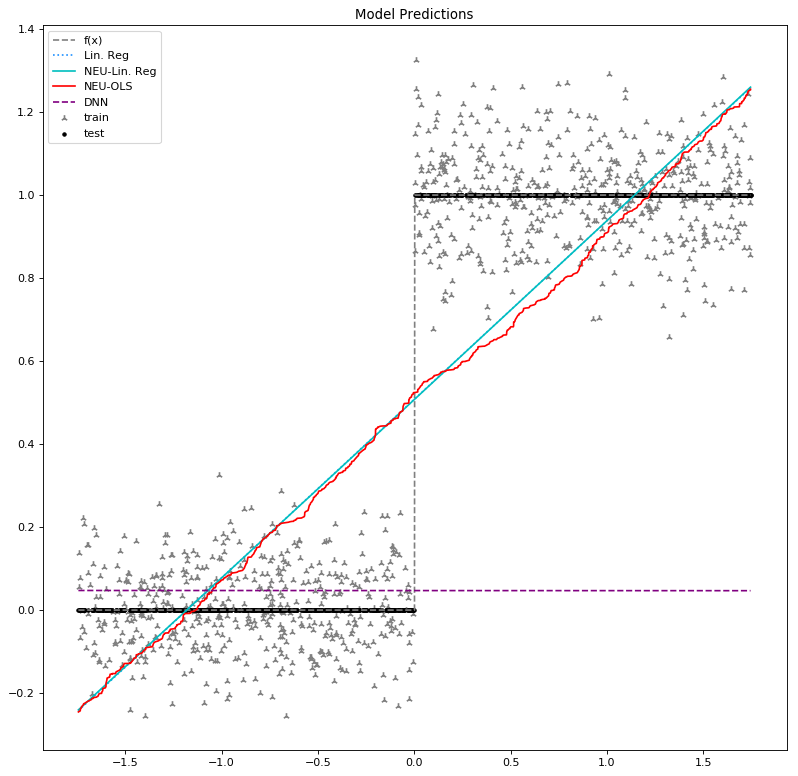

In [9]:
# Initialize Plot #
#-----------------#
fig = plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')

# Generate Plots #
#----------------#

# Plot Signal
plt.plot(np.array(data_x_test_raw).reshape(-1,),data_y_test,color='gray',label='f(x)',linestyle='--')
# Plot Data
plt.scatter(np.array(data_x_raw).reshape(-1,),data_y,color='gray',label='train', marker = '2')
plt.scatter(np.array(data_x_test_raw).reshape(-1,),data_y_test,color='black',label='test', marker = '.')

#----------#
# Model(s) #
#----------#
# Ordinary Linear Regression (OLS)
plt.plot(np.array(data_x_test_raw).reshape(-1,),ENET_OLS_y_hat_test, color = 'dodgerblue',linestyle=":", label='Lin. Reg')

# Plot NEU-OLS
plt.plot(np.array(data_x_test_raw).reshape(-1,),NEU_OLS_y_hat_test, color = 'c',label='NEU-Lin. Reg')
plt.plot(np.array(data_x_test_raw).reshape(-1,),NEU_OLS_y_hat_test_FC, color = 'red',label='NEU-OLS')
plt.plot(np.array(data_x_test_raw).reshape(-1,),ffNN_y_hat_test, color = 'purple',linestyle="--",  label='DNN')

# Format Plot #
#-------------#
plt.legend(loc="upper left")
plt.title("Model Predictions")

# Export #
#--------#
# SAVE Figure to .eps
plt.savefig('./outputs/plotsANDfigures/OLS.pdf', format='pdf')
# Show Plot
if is_visuallty_verbose == True:
    plt.show(block=False)

#### Error Distribution NEU-OLS

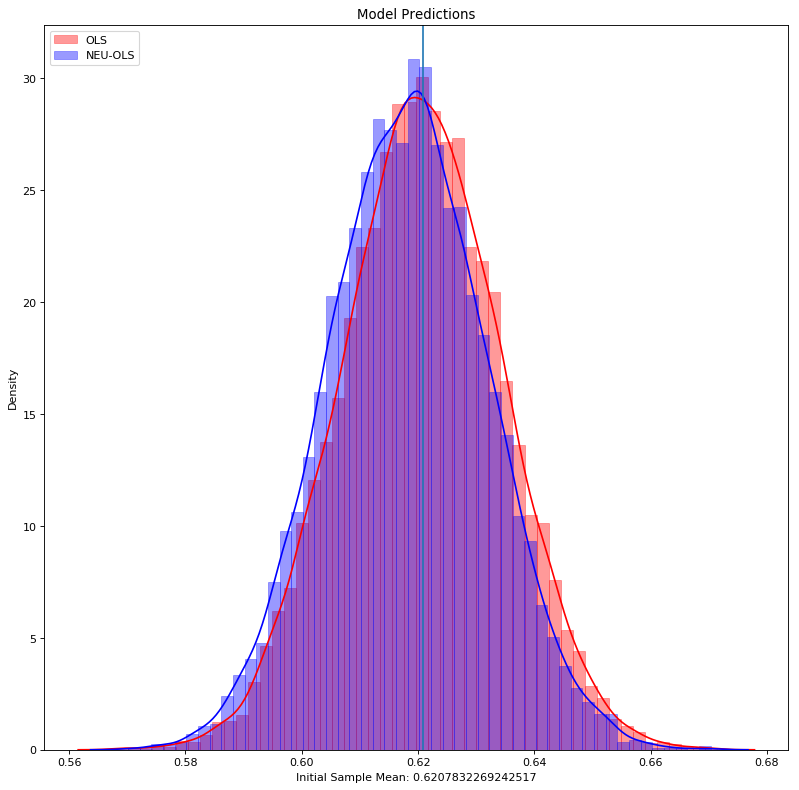

In [10]:
get_Error_distribution_plots(data_y_test,ENET_OLS_y_hat_test,NEU_OLS_y_hat_test_FC,"OLS")

#### Error Distribution NEU-ENET

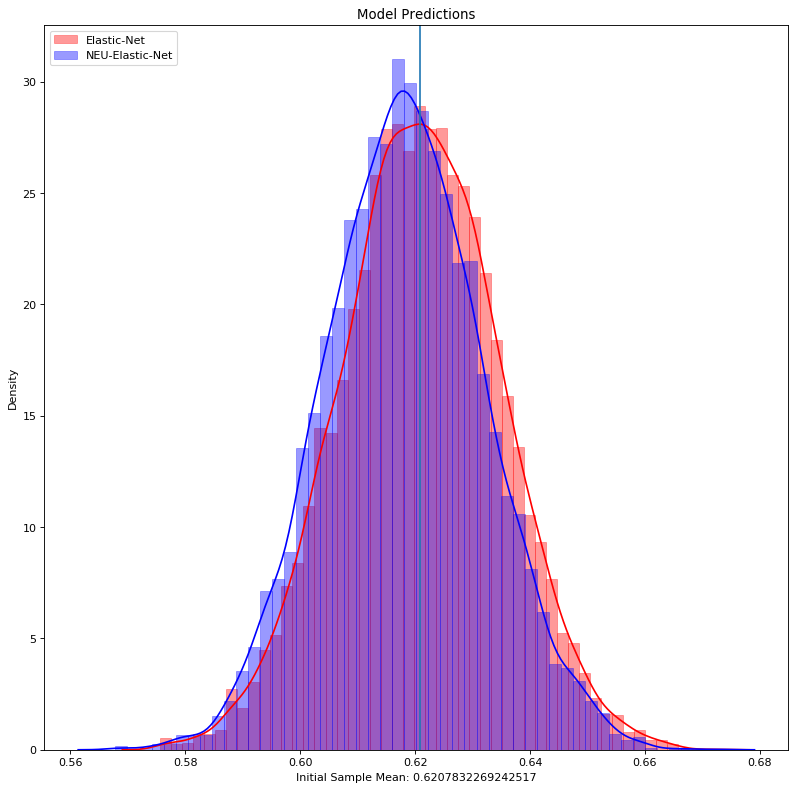

In [11]:
get_Error_distribution_plots(data_y_test,ENET_OLS_y_hat_test,NEU_OLS_y_hat_test_FC,"Elastic-Net")

#### Comparison between Elastic-Net and NEU-ENET

In [12]:
#-----------------#
# Linear Model(s) #
#-----------------#
# Elastic-Net Performance
print("Elastic-Net Performance:")
print(reporter(ENET_OLS_y_hat_train,ENET_OLS_y_hat_test,data_y,data_y_test))


# ffNN
print("Benchmark: DNN (ffNN)")
print(reporter(ffNN_y_hat_train,ffNN_y_hat_test,data_y,data_y_test))

# NEU-Elastic Net Performance
print("NEU-ENET Performance:")
print(reporter(NEU_OLS_y_hat_train,NEU_OLS_y_hat_test,data_y,data_y_test))

# NEU-OLS Fully Coupled
print("Benchmark: NEU-OLS Coupled")
print(reporter(NEU_OLS_y_hat_train_FC,NEU_OLS_y_hat_test_FC,data_y,data_y_test))

Elastic-Net Performance:
                 Train       Test
Er. 95L  -1.688022e-02  -0.047634
Er. Mean  2.131628e-17  -0.032223
Er. 95U   1.706307e-02  -0.016699
MAE       2.227277e-01   0.205180
MSE       7.517724e-02   0.061606
MAPE      1.445381e+02  63.567131
Benchmark: DNN (ffNN)
                Train         Test
Er. 95L      0.429613     0.413047
Er. Mean     0.461012     0.444058
Er. 95U      0.492985     0.475068
MAE          0.527415     0.491972
MSE          0.472800     0.447233
MAPE      1125.864839  1050.661621
NEU-ENET Performance:
               Train       Test
Er. 95L    -0.017148  -0.047496
Er. Mean    0.000001  -0.032243
Er. 95U     0.016766  -0.016734
MAE         0.222706   0.205123
MSE         0.075179   0.061567
MAPE      680.886426  63.603668
Benchmark: NEU-OLS Coupled
               Train       Test
Er. 95L    -0.031655  -0.032400
Er. Mean   -0.015231  -0.016989
Er. 95U     0.001716  -0.001567
MAE         0.220503   0.207852
MSE         0.074178   0.062936
MAPE 

In [13]:
print("Time to Trian NEU-OLS: "+str(end - start))

Time to Trian NEU-OLS: 12.229450941085815


---
# Non-Linear Models
---

### NEU-Kernel Ridge Regression *(decoupled implementation)*

In [14]:
# 2) Perform Linear Regression on Feature-Space #
#===============================================#
NEU_KReg_y_hat_train_pre,NEU_KReg_y_hat_test_pre, NEU_KReg_model = get_Kernel_Ridge_Regressor(data_x_in = data_x_featured_train,
                                                                                       data_x_test_in = data_x_featured_test,
                                                                                       data_y_in = data_y)


NEU_KReg_y_hat_train = NEU_KReg_y_hat_train_pre
NEU_KReg_y_hat_test = NEU_KReg_y_hat_test_pre

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Batch computation too fast (0.0670s.) Setting batch_size=2.
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    0.4s finished


#### Visual Comaprison between the Kernel Ridge Regression and the NEU-Kernel Ridge Regression models:

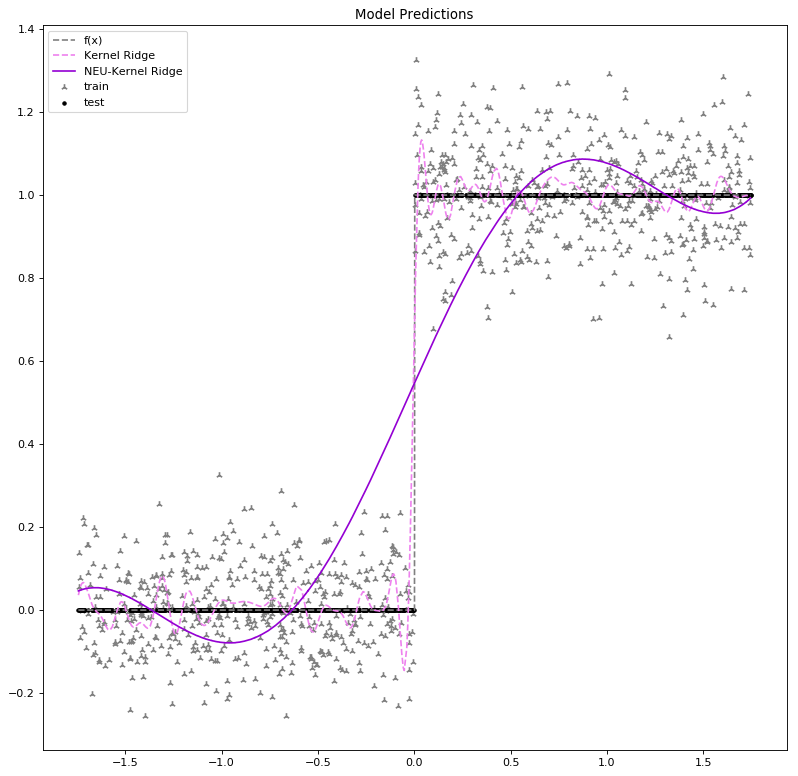

In [15]:
# Initialize Plot #
#-----------------#
fig = plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')

# Generate Plots #
#----------------#

# Plot Signal
plt.plot(np.array(data_x_test_raw).reshape(-1,),data_y_test,color='gray',label='f(x)',linestyle='--')
# Plot Data
plt.scatter(np.array(data_x_raw).reshape(-1,),data_y,color='gray',label='train', marker = '2')
plt.scatter(np.array(data_x_test_raw).reshape(-1,),data_y_test,color='black',label='test', marker = '.')

#----------#
# Model(s) #
#----------#
# Kernel Ridge Regressor
plt.plot(np.array(data_x_test_raw).reshape(-1,),f_hat_kernel_ridge_test,color='violet',linestyle="--",label='Kernel Ridge')
# NEU-Kernel Ridge Regressor
plt.plot(np.array(data_x_test_raw).reshape(-1,),NEU_KReg_y_hat_test,color='darkviolet',label='NEU-Kernel Ridge')

# Format Plot #
#-------------#
plt.legend(loc="upper left")
plt.title("Model Predictions")

# Export #
#--------#
# SAVE Figure to .eps
plt.savefig('./outputs/plotsANDfigures/Kernel_Ridge.pdf', format='pdf')
# Show Plot
if is_visuallty_verbose == True:
    plt.show(block=False)

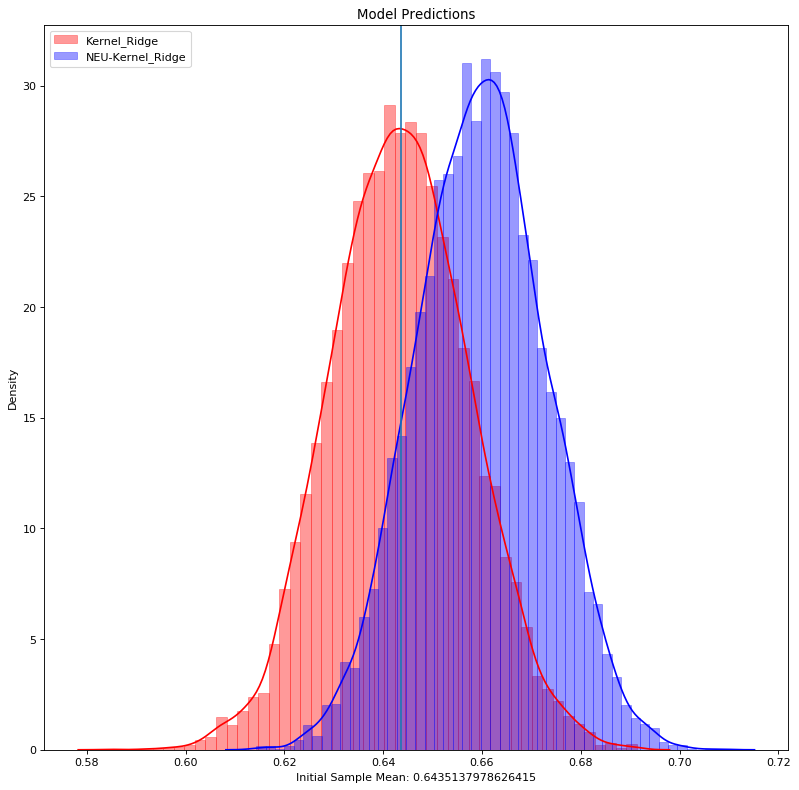

In [16]:
get_Error_distribution_plots(data_y_test,f_hat_kernel_ridge_test,NEU_KReg_y_hat_test,"Kernel_Ridge")

#### Numerical Comparison between the Kernel Ridge regressor and NEU-Kernel Ridge regressor models:

In [17]:
#-----------------------#
# Kernel Ridge Model(s) #
#-----------------------#
# Kernel Ridge Performance
print("Kernel Ridge-Performance:")
print(reporter(f_hat_kernel_ridge_train,f_hat_kernel_ridge_test,data_y,data_y_test))

# NEU-Kernel Ridge Performance
print("NEU-Kernel Ridge-Performance:")
print(reporter(NEU_KReg_y_hat_train,NEU_KReg_y_hat_test,data_y,data_y_test))

Kernel Ridge-Performance:
               Train       Test
Er. 95L    -0.006952  -0.009884
Er. Mean    0.000010  -0.006081
Er. 95U     0.007064  -0.002493
MAE         0.089643   0.031606
MSE         0.012934   0.003599
MAPE      722.236406  52.099953
NEU-Kernel Ridge-Performance:
               Train       Test
Er. 95L    -0.011982  -0.034830
Er. Mean    0.000002  -0.024630
Er. 95U     0.012699  -0.014618
MAE         0.146603   0.107678
MSE         0.038971   0.028100
MAPE      220.242268  56.326120


## Tree Model(s):
*Naturally, all of these have a decoupled implementation*.

In [18]:
# 2) Perform Linear Regression on Feature-Space #
#===============================================#
NEU_GBRF_y_hat_train_pre,NEU_GBRF_y_hat_test_pre, GBRF_w_NEU_features = get_GBRF(X_train = data_x_featured_train,
                                                                         X_test = data_x_featured_test,
                                                                         y_train = data_y)

NEU_GBRF_y_hat_train = NEU_GBRF_y_hat_train_pre
NEU_GBRF_y_hat_test = NEU_GBRF_y_hat_test_pre

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    0.8s finished


#### Visual Comaprison between the GBRF and the NEU-GBRF models:

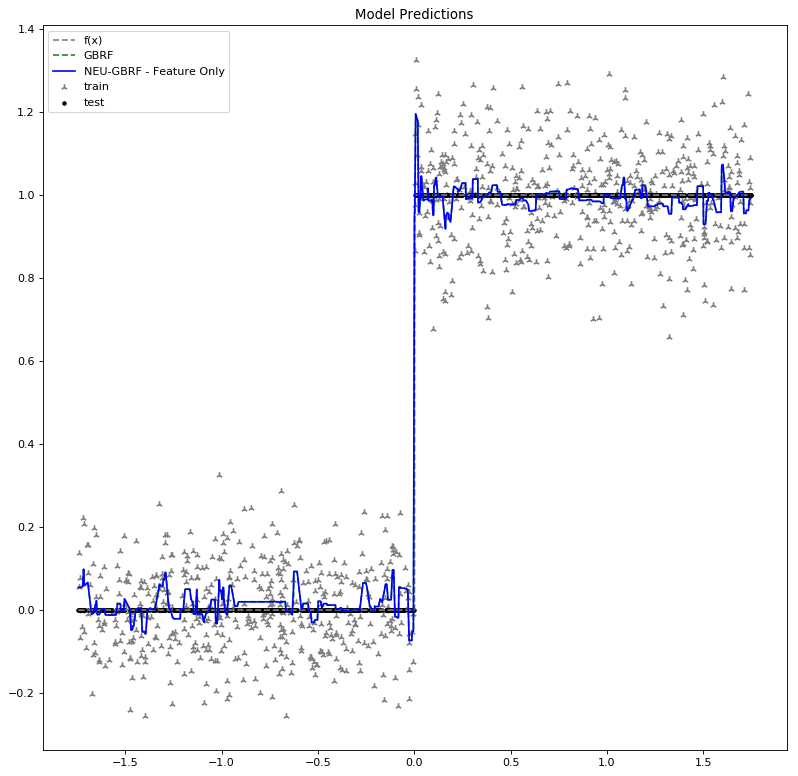

In [19]:
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')

# Generate Plots #
#----------------#

# Plot Signal
plt.plot(np.array(data_x_test_raw).reshape(-1,),data_y_test,color='gray',label='f(x)',linestyle='--')
# Plot Data
plt.scatter(np.array(data_x_raw).reshape(-1,),data_y,color='gray',label='train', marker = '2')
plt.scatter(np.array(data_x_test_raw).reshape(-1,),data_y_test,color='black',label='test', marker = '.')

#----------#
# Model(s) #
#----------#
# Plot Gradient-Boosted Random Forest Regressor (GBRF):
plt.plot(np.array(data_x_test_raw).reshape(-1,),GBRF_y_hat_test, linestyle="--", color = 'forestgreen', label='GBRF')
# Plot NEU-GBRF:
plt.plot(np.array(data_x_test_raw).reshape(-1,),NEU_GBRF_y_hat_test, color = 'blue',label='NEU-GBRF - Feature Only')


# Format Plot #
#-------------#
plt.legend(loc="upper left")
plt.title("Model Predictions")


# Export #
#--------#
# SAVE Figure to .eps
plt.savefig('./outputs/plotsANDfigures/GBRF.pdf', format='pdf')
# Show Plot
if is_visuallty_verbose == True:
    plt.show(block=False)

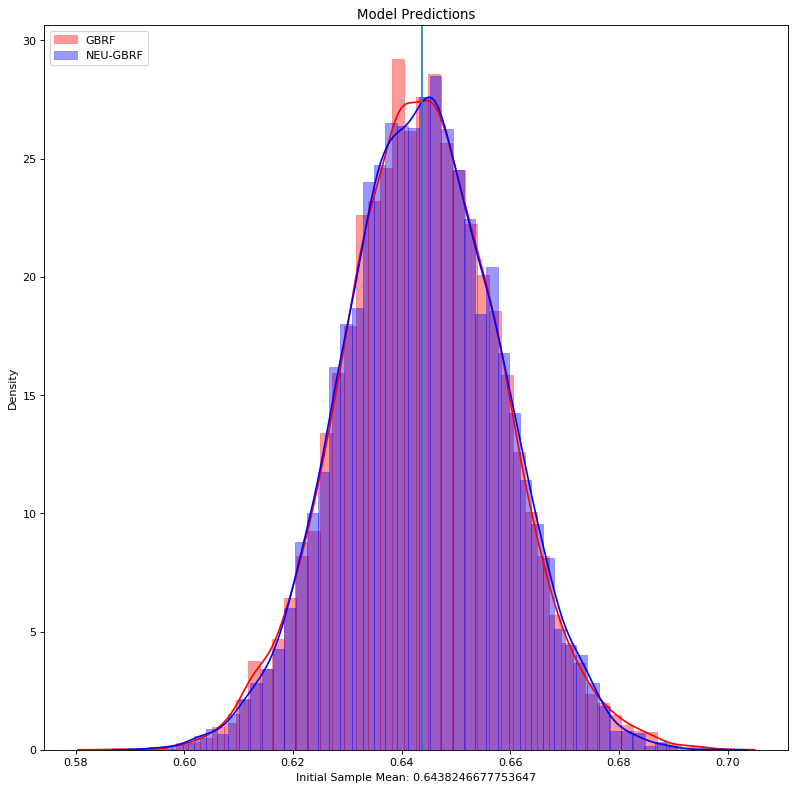

In [20]:
get_Error_distribution_plots(data_y_test,GBRF_y_hat_test,NEU_GBRF_y_hat_test,"GBRF")

#### Numerical Comparison between the GBRF and NEU-GBRF models:

In [21]:
#---------------#
# Tree Model(s) #
#---------------#
# GBRF Performance
print("GBRF-Performance:")
print(reporter(GBRF_y_hat_train,GBRF_y_hat_test,data_y,data_y_test))

# NEU-GBRF Performance
print("NEU-GBRF-Performance:")
print(reporter(NEU_GBRF_y_hat_train,NEU_GBRF_y_hat_test,data_y,data_y_test))

GBRF-Performance:
                 Train       Test
Er. 95L  -6.007158e-03  -0.005950
Er. Mean -4.352074e-17  -0.003065
Er. 95U   5.936761e-03  -0.000586
MAE       7.831667e-02   0.023738
MSE       9.670009e-03   0.001931
MAPE      4.836594e+02  51.926804
NEU-GBRF-Performance:
                 Train       Test
Er. 95L  -6.172428e-03  -0.005996
Er. Mean -8.348877e-17  -0.003090
Er. 95U   6.048516e-03  -0.000636
MAE       7.832407e-02   0.023744
MSE       9.669169e-03   0.001932
MAPE      4.814707e+02  51.926361


---
## Neural Networks: 
---
### NEU-ffNN

#### A) Fully-Coupled Implementation
- Train feature-map + ffNN ($\hat{f}\circ \phi$) in one go.

In [22]:
tf.random.set_seed(2020)
NEU_ffNN_y_hat_train, NEU_ffNN_y_hat_test = build_NEU_ffNN_w_feature_only(n_folds = CV_folds, 
                                                           n_jobs = n_jobs, 
                                                           n_iter = n_iter, 
                                                           param_grid_in = param_grid_NEU_Nets, 
                                                           X_train = data_x, 
                                                           y_train = data_y,
                                                           X_test = data_x_test)

Training NEU-ffNN (Fully Coupled)
Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    6.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    6.0s finished


Epoch 1/2
125/125 [==============================] - 0s 1ms/step - loss: 0.5659 - mse: 0.5348 - mae: 0.5561 - mape: 135.7349
Epoch 2/2
125/125 [==============================] - 0s 905us/step
NEU-ffNN (Fully Coupled): Trained!
NEU-ffNN (Fully Coupled): Saving
NEU-ffNN (Fully Coupled): Saved


---

**Note:** The following two models are purely out of personal curiosity and are not included in the paper.  Feel free to use them, they perform well. 

---

## Visualization

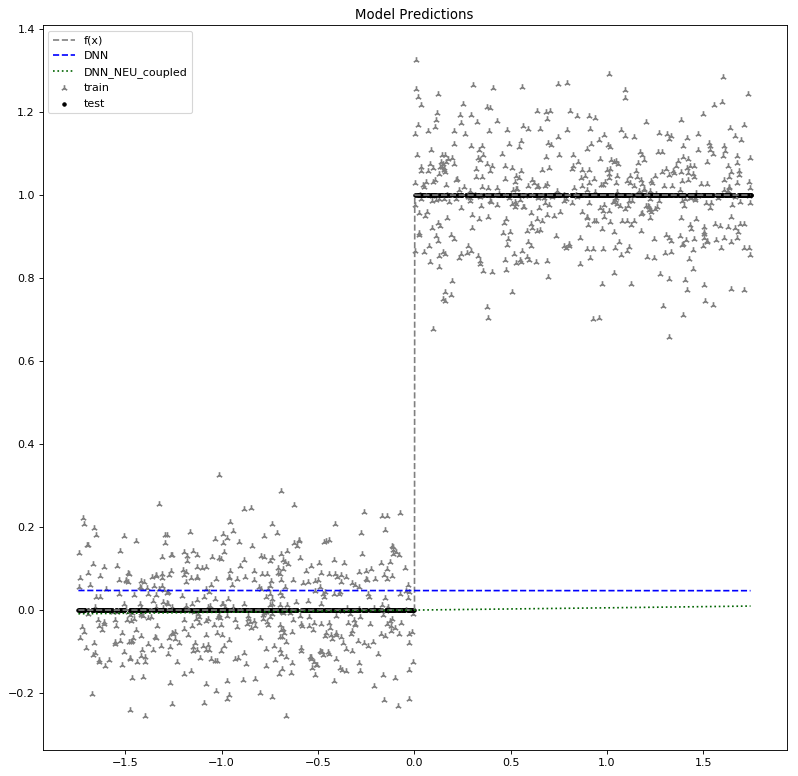

In [23]:
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')

# Generate Plots #
#----------------#

# Plot Signal
plt.plot(np.array(data_x_test_raw).reshape(-1,),data_y_test,color='gray',label='f(x)',linestyle='--')
# Plot Data
plt.scatter(np.array(data_x_raw).reshape(-1,),data_y,color='gray',label='train', marker = '2')
plt.scatter(np.array(data_x_test_raw).reshape(-1,),data_y_test,color='black',label='test', marker = '.')

#--------------------#
# Benchmark Model(s) #
#--------------------#
# Plot ffNN
plt.plot(np.array(data_x_test_raw).reshape(-1,),ffNN_y_hat_test, color = 'blue',linestyle="--",  label='DNN')


#--------------#
# NEU-Model(s) #
#--------------#
# Plot NEU-ffNN (Training Variants)
plt.plot(np.array(data_x_test_raw).reshape(-1,),NEU_ffNN_y_hat_test, linestyle=":", color = 'darkgreen',label='DNN_NEU_coupled')



# Format Plot #
#-------------#
plt.legend(loc="upper left")
plt.title("Model Predictions")

# Export #
#--------#
# SAVE Figure to .eps
plt.savefig('./outputs/plotsANDfigures/Neural_Network_Models.pdf', format='pdf')
# Show Plot
if is_visuallty_verbose == True:
    plt.show(block=False)

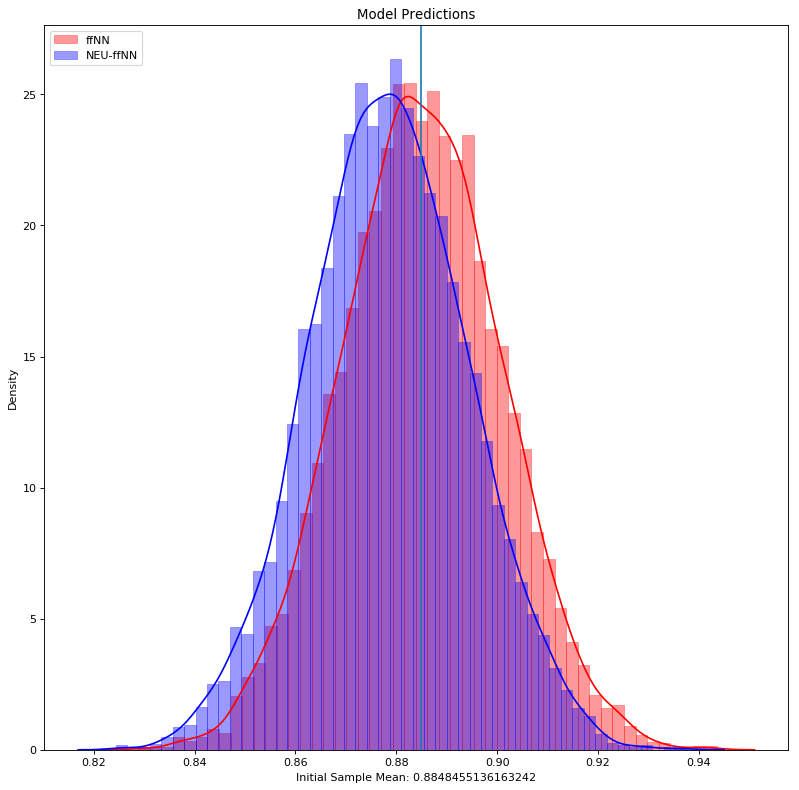

In [24]:
get_Error_distribution_plots(data_y_test,ffNN_y_hat_test,NEU_ffNN_y_hat_test,"ffNN")

---
---
---

---
# Result(s)
---

## Generate Results Table(s):

In [25]:
#==========#
# Training #
#==========#
train_performance  = pd.DataFrame({"Smoothin Splines": reporter(f_hat_smoothing_splines_train,f_hat_smoothing_splines_test,data_y,data_y_test).iloc[:,0],
                                   "LOESS": reporter(LOESS_prediction_train,LOESS_prediction_test,data_y,data_y_test).iloc[:,0],
                                   "Elastic Net": reporter(ENET_OLS_y_hat_train,ENET_OLS_y_hat_test,data_y,data_y_test).iloc[:,0],
                                   "NEU-OLS": reporter(NEU_OLS_y_hat_train_FC,NEU_OLS_y_hat_test_FC,data_y,data_y_test).iloc[:,0],
                                   "NEU-ENET": reporter(NEU_OLS_y_hat_train,NEU_OLS_y_hat_test,data_y,data_y_test).iloc[:,0],
                                   "Kernel": reporter(f_hat_kernel_ridge_train,f_hat_kernel_ridge_test,data_y,data_y_test).iloc[:,0],
                                   "NEU-KerRidge": reporter(NEU_KReg_y_hat_train,NEU_KReg_y_hat_test,data_y,data_y_test).iloc[:,0],
                                   "GBRF": reporter(GBRF_y_hat_train,GBRF_y_hat_test,data_y,data_y_test).iloc[:,0],
                                   "NEU-GBRF": reporter(NEU_GBRF_y_hat_train,NEU_GBRF_y_hat_test,data_y,data_y_test).iloc[:,0],
                                   "ffNN": reporter(ffNN_y_hat_train,ffNN_y_hat_test,data_y,data_y_test).iloc[:,0],
                                   "NEU-ffNN (Coupled)": reporter(NEU_ffNN_y_hat_train,NEU_ffNN_y_hat_test,data_y,data_y_test).iloc[:,0]}).transpose()


train_performance.to_latex("./outputs/tables/Train_performance.tex")

#=========#
# Testing #
#=========#
test__performance  = pd.DataFrame({"Smoothin Splines": reporter(f_hat_smoothing_splines_train,f_hat_smoothing_splines_test,data_y,data_y_test).iloc[:,1],
                                   "LOESS": reporter(LOESS_prediction_train,LOESS_prediction_test,data_y,data_y_test).iloc[:,1],
                                   "Elastic Net": reporter(ENET_OLS_y_hat_train,ENET_OLS_y_hat_test,data_y,data_y_test).iloc[:,1],
                                   "NEU-OLS": reporter(NEU_OLS_y_hat_train_FC,NEU_OLS_y_hat_test_FC,data_y,data_y_test).iloc[:,1],
                                   "NEU-ENET": reporter(NEU_OLS_y_hat_train,NEU_OLS_y_hat_test,data_y,data_y_test).iloc[:,1],
                                   "Kernel": reporter(f_hat_kernel_ridge_train,f_hat_kernel_ridge_test,data_y,data_y_test).iloc[:,1],
                                   "NEU-KerRidge": reporter(NEU_KReg_y_hat_train,NEU_KReg_y_hat_test,data_y,data_y_test).iloc[:,1],
                                   "GBRF": reporter(GBRF_y_hat_train,GBRF_y_hat_test,data_y,data_y_test).iloc[:,1],
                                   "NEU-GBRF": reporter(NEU_GBRF_y_hat_train,NEU_GBRF_y_hat_test,data_y,data_y_test).iloc[:,1],
                                   "ffNN": reporter(ffNN_y_hat_train,ffNN_y_hat_test,data_y,data_y_test).iloc[:,1],
                                   "NEU-ffNN (Coupled)": reporter(NEU_ffNN_y_hat_train,NEU_ffNN_y_hat_test,data_y,data_y_test).iloc[:,1]}).transpose()

test__performance.to_latex("./outputs/tables/Test_performance.tex")

# Visualize Predictions

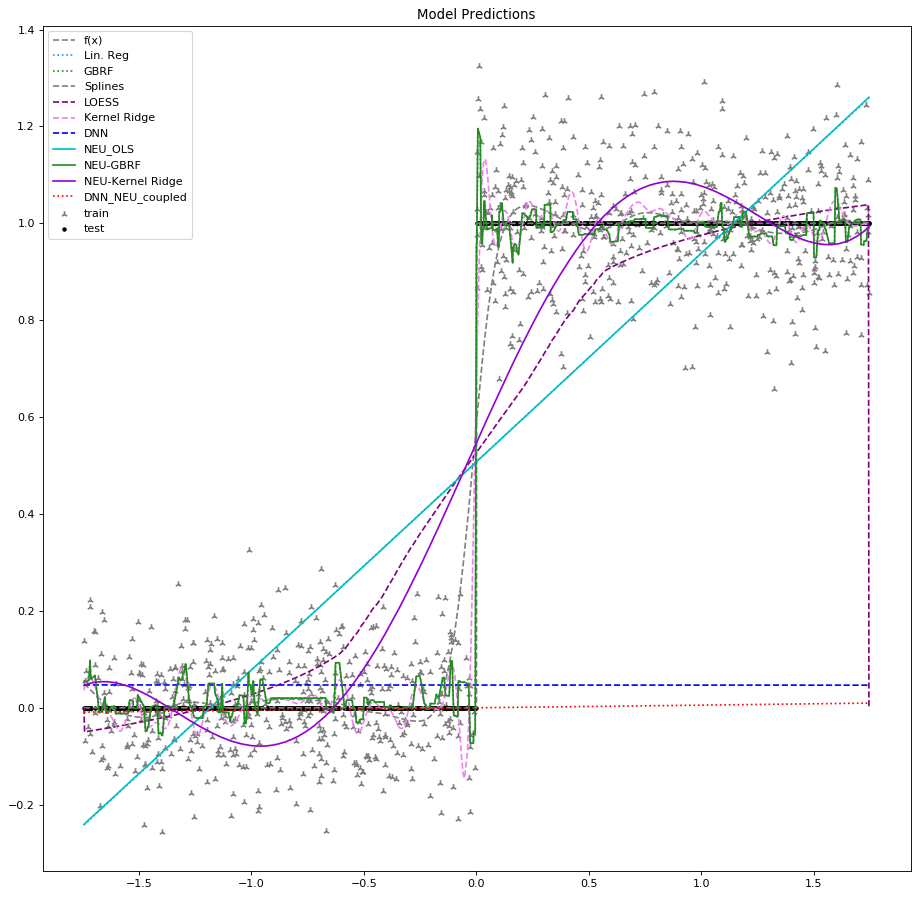

In [26]:
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(14, 14), dpi=80, facecolor='w', edgecolor='k')

# Generate Plots #
#----------------#

# Plot Signal
plt.plot(np.array(data_x_test_raw).reshape(-1,),data_y_test,color='gray',label='f(x)',linestyle='--')
# Plot Data
plt.scatter(np.array(data_x_raw).reshape(-1,),data_y,color='gray',label='train', marker = '2')
plt.scatter(np.array(data_x_test_raw).reshape(-1,),data_y_test,color='black',label='test', marker = '.')

#--------------------#
# Benchmark Model(s) #
#--------------------#
# Ordinary Linear Regression (OLS)
plt.plot(np.array(data_x_test_raw).reshape(-1,),ENET_OLS_y_hat_test, color = 'dodgerblue',linestyle=":", label='Lin. Reg')
# Plot Gradient-Boosted Random Forest Regressor (GBRF):
plt.plot(np.array(data_x_test_raw).reshape(-1,),GBRF_y_hat_test, color = 'forestgreen',linestyle=":", label='GBRF')
# Plot Non-Linar Benchmark(s): Classical
plt.plot(np.array(data_x_test_raw).reshape(-1,),f_hat_smoothing_splines_test,color='grey',linestyle="--",label='Splines')
plt.plot(np.array(data_x_test_raw).reshape(-1,),LOESS_prediction_test,color='purple',linestyle="--",label='LOESS')
# Kernel Ridge Regressor
plt.plot(np.array(data_x_test_raw).reshape(-1,),f_hat_kernel_ridge_test,color='violet',linestyle="--",label='Kernel Ridge')
# Plot ffNN
plt.plot(np.array(data_x_test_raw).reshape(-1,),ffNN_y_hat_test, color = 'blue',linestyle="--",  label='DNN')


#--------------#
# NEU-Model(s) #
#--------------#
# Plot NEU-OLS
plt.plot(np.array(data_x_test_raw).reshape(-1,),NEU_OLS_y_hat_test, color = 'c',label='NEU_OLS')
# Plot NEU-GBRF:
plt.plot(np.array(data_x_test_raw).reshape(-1,),NEU_GBRF_y_hat_test, color = 'forestgreen',label='NEU-GBRF')
# NEU-Kernel Ridge Regressor
plt.plot(np.array(data_x_test_raw).reshape(-1,),NEU_KReg_y_hat_test,color='darkviolet',label='NEU-Kernel Ridge')
# Plot NEU-ffNN (Training Variants)
plt.plot(np.array(data_x_test_raw).reshape(-1,),NEU_ffNN_y_hat_test, linestyle=":", color = 'red',label='DNN_NEU_coupled')


# Format Plot #
#-------------#
plt.legend(loc="upper left")
plt.title("Model Predictions")

# Export #
#--------#
# SAVE Figure to .eps
plt.savefig('./outputs/plotsANDfigures/Full_Picture.pdf', format='pdf')
# Show Plot
if is_visuallty_verbose == True:
    plt.show(block=False)

 ---

## Performance Report
- First, we print the comparison tables (so it can be viewed from the command-line if it is being run live on a grid/cluster/remotely).
- Second, we display the training and testing performances in clean dataframes.

In [27]:
#--------------------#
# Classical Model(s) #
#--------------------#
# OLS Performance
print("OLS-Performance:")
# print(reporter(OLS_y_hat_train,OLS_y_hat_test,data_y,data_y_test))

# NEU-OLS Performance
print("NEU-OLS-Performance:")
print(reporter(NEU_OLS_y_hat_train,NEU_OLS_y_hat_test,data_y,data_y_test))

OLS-Performance:
NEU-OLS-Performance:
               Train       Test
Er. 95L    -0.016898  -0.047331
Er. Mean    0.000001  -0.032243
Er. 95U     0.017191  -0.016915
MAE         0.222706   0.205123
MSE         0.075179   0.061567
MAPE      680.886426  63.603668


In [28]:
#-----------------------#
# Kernel Ridge Model(s) #
#-----------------------#
# Kernel Ridge Performance
print("Kernel Ridge-Performance:")
print(reporter(f_hat_kernel_ridge_train,f_hat_kernel_ridge_test,data_y,data_y_test))

# NEU-Kernel Ridge Performance
print("NEU-Kernel Ridge-Performance:")
print(reporter(NEU_KReg_y_hat_train,NEU_KReg_y_hat_test,data_y,data_y_test))

Kernel Ridge-Performance:
               Train       Test
Er. 95L    -0.007071  -0.009933
Er. Mean    0.000010  -0.006081
Er. 95U     0.007080  -0.002485
MAE         0.089643   0.031606
MSE         0.012934   0.003599
MAPE      722.236406  52.099953
NEU-Kernel Ridge-Performance:
               Train       Test
Er. 95L    -0.012446  -0.035003
Er. Mean    0.000002  -0.024630
Er. 95U     0.012220  -0.014398
MAE         0.146603   0.107678
MSE         0.038971   0.028100
MAPE      220.242268  56.326120


In [29]:
#---------------#
# Tree Model(s) #
#---------------#
# GBRF Performance
print("GBRF-Performance:")
print(reporter(GBRF_y_hat_train,GBRF_y_hat_test,data_y,data_y_test))

# NEU-GBRF Performance
print("NEU-GBRF-Performance:")
print(reporter(NEU_GBRF_y_hat_train,NEU_GBRF_y_hat_test,data_y,data_y_test))

GBRF-Performance:
                 Train       Test
Er. 95L  -6.224373e-03  -0.006012
Er. Mean -4.352074e-17  -0.003065
Er. 95U   6.167925e-03  -0.000554
MAE       7.831667e-02   0.023738
MSE       9.670009e-03   0.001931
MAPE      4.836594e+02  51.926804
NEU-GBRF-Performance:
                 Train       Test
Er. 95L  -6.136622e-03  -0.006059
Er. Mean -8.348877e-17  -0.003090
Er. 95U   5.989919e-03  -0.000540
MAE       7.832407e-02   0.023744
MSE       9.669169e-03   0.001932
MAPE      4.814707e+02  51.926361


In [30]:
#-----------------------------------------------------#
# Classical Non-Linear Univariate Regression Model(s) #
#-----------------------------------------------------#
# Splines Performance
print("Splines-Performance:")
print(reporter(f_hat_smoothing_splines_train,f_hat_smoothing_splines_test,data_y,data_y_test))

# Loess Performance
print("LOESS Performance:")
print(reporter(LOESS_prediction_train,LOESS_prediction_test,data_y,data_y_test))

Splines-Performance:
                 Train       Test
Er. 95L  -8.477826e-03  -0.016451
Er. Mean -8.750334e-15  -0.010800
Er. 95U   8.216183e-03  -0.005532
MAE       9.905079e-02   0.033107
MSE       1.812052e-02   0.007895
MAPE      1.648880e+03  52.230601
LOESS Performance:
               Train      Test
Er. 95L    -0.010083 -0.034028
Er. Mean    0.003596 -0.021968
Er. 95U     0.017235 -0.009671
MAE         0.163635  0.124161
MSE         0.049068  0.038780
MAPE      259.650152       NaN


In [31]:
#--------------#
# DNN Model(s) #
#--------------#
# ffNN Performance
print("ffNN-Performance:")
print(reporter(ffNN_y_hat_train,ffNN_y_hat_test,data_y,data_y_test))

# NEU-ffNN Performance
print("NEU-ffNN (Coupled) Performance:") #Readout Form!
print(reporter(NEU_ffNN_y_hat_train,NEU_ffNN_y_hat_test,data_y,data_y_test))

# print("NEU-ffNN (Decoupled) Performance:")
# print(reporter(NEU_ffNN_y_hat_train_Dcpld,NEU_ffNN_y_hat_test_Dcpld,data_y,data_y_test))

ffNN-Performance:
                Train         Test
Er. 95L      0.428825     0.413052
Er. Mean     0.461012     0.444058
Er. 95U      0.493394     0.476066
MAE          0.527415     0.491972
MSE          0.472800     0.447233
MAPE      1125.864839  1050.661621
NEU-ffNN (Coupled) Performance:
                 Train          Test
Er. 95L       0.476724      0.460051
Er. Mean      0.507888      0.490735
Er. 95U       0.539239      0.520579
MAE           0.545129      0.490735
MSE           0.513533      0.486040
MAPE      85881.012565  42613.923903


# Report

## Re-Summarize Learning Problem for easy recap :)

In [32]:
print("Simulation Confiugration Information:")
print(" ")
print("=========================================================================================================================================================")
print(the_facts)
print("=========================================================================================================================================================")
print(" ")

Simulation Confiugration Information:
 
We're plotting the function: jumpdiscontinuity with 0.1 additive noise, a distortion/model uncertainty level of 0.1, and an out-of sample window on either side of the input space of: 0.  We train using 1000 datapoints and have a test set conisting of 0.75% percent of the total generated data.
 


## Train-Set Performance

In [33]:
train_performance

,Er. 95L,Er. Mean,Er. 95U,MAE,MSE,MAPE
Smoothin Splines,-0.008343,-8.750334e-15,0.008437,0.099051,0.018121,1648.880150
LOESS,-0.009812,3.596431e-03,0.017023,0.163635,0.049068,259.650152
Elastic Net,-0.017159,2.131628e-17,0.016760,0.222728,0.075177,144.538113
NEU-OLS,-0.032000,-1.523065e-02,0.001441,0.220503,0.074178,104.186724
NEU-ENET,-0.017259,1.102072e-06,0.016856,0.222706,0.075179,680.886426
Kernel,-0.006886,1.044155e-05,0.007099,0.089643,0.012934,722.236406
NEU-KerRidge,-0.012341,2.020618e-06,0.012350,0.146603,0.038971,220.242268
GBRF,-0.006035,-4.352074e-17,0.006108,0.078317,0.009670,483.659350
NEU-GBRF,-0.006252,-8.348877e-17,0.006064,0.078324,0.009669,481.470681
ffNN,0.428863,4.610124e-01,0.493200,0.527415,0.472800,1125.864839


## Test-Set Performance

In [34]:
test__performance

,Er. 95L,Er. Mean,Er. 95U,MAE,MSE,MAPE
Smoothin Splines,-0.016527,-0.010800,-0.005410,0.033107,0.007895,52.230601
LOESS,-0.034007,-0.021968,-0.009754,0.124161,0.038780,NaN
Elastic Net,-0.047490,-0.032223,-0.016718,0.205180,0.061606,63.567131
NEU-OLS,-0.032499,-0.016989,-0.001412,0.207852,0.062936,64.612732
NEU-ENET,-0.047488,-0.032243,-0.017381,0.205123,0.061567,63.603668
Kernel,-0.009834,-0.006081,-0.002550,0.031606,0.003599,52.099953
NEU-KerRidge,-0.034887,-0.024630,-0.014365,0.107678,0.028100,56.326120
GBRF,-0.005979,-0.003065,-0.000496,0.023738,0.001931,51.926804
NEU-GBRF,-0.005982,-0.003090,-0.000607,0.023744,0.001932,51.926361
ffNN,0.413050,0.444058,0.476063,0.491972,0.447233,1050.661621


#### The END

---